# Bacterial Image Classifier Using Transfer Learning

In this project we use a transfer learning approach to classify 33 types of bacterial species from microscopy images. We test multiple different CNN models, which are fine-tuned on our training set. Results show high classification accuracy across these models. We note that while performance on the rod-shaped bacterial species was very good, most models could not accurately distinguish between the spherical bacterial species.

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import keras
import datetime

from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, EfficientNetV2L, ResNet50, InceptionV3
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.efficientnet_v2 import (
    preprocess_input as efficientnet_v2_preprocess,
)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import (
    preprocess_input as inception_preprocess,
)

# %load_ext nb_black

In [2]:
# Path for datasets
bact_path = "C:/Users/rparg/Documents/Data/bacteria_classifier/Train"
test_path = "C:/Users/rparg/Documents/Data/bacteria_classifier/Test"

In [3]:
def create_image_generators(path, gen_arg_dict, image_dict):
    train_datagen = ImageDataGenerator(**gen_arg_dict)

    train_generator = train_datagen.flow_from_directory(
        path,
        **image_dict,
        class_mode="sparse",
        subset="training",
    )

    validation_generator = train_datagen.flow_from_directory(
        path,
        **image_dict,
        class_mode="sparse",
        subset="validation",
    )

    return train_generator, validation_generator


def create_image_test_generators(path, preprocess, image_dict):
    # No image augmentation for test set, so requies separate generator
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess)

    test_generator = test_datagen.flow_from_directory(
        path,
        **image_dict,
        class_mode="sparse",
        shuffle=False,
    )

    return test_generator


def add_head_to_base_model(basemodel, num_classes=33, dense_size=512, dropout_size=0.2):
    for layer in basemodel.layers:
        layer.trainable = False

    headModel = basemodel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(dense_size, activation="relu")(headModel)
    headModel = Dropout(dropout_size)(headModel)
    headModel = Dense(dense_size, activation="relu")(headModel)
    headModel = Dropout(dropout_size)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    model = Model(inputs=basemodel.input, outputs=headModel)

    return model


def set_callbacks(path):
    log_dir = path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    return callbacks


def train_image_model(
    model,
    train_generator,
    validation_generator,
    init_lr=0.001,
    num_epochs=30,
    batch_size=32,
    callbacks=None,
):
    opt = Adam(learning_rate=init_lr, decay=init_lr / num_epochs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=opt,
        metrics=["sparse_categorical_accuracy"],
    )

    model_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
    )

    return model, model_history


def plot_train_val_history(model_history, epochs):
    acc = model_history.history["sparse_categorical_accuracy"]
    val_acc = model_history.history["val_sparse_categorical_accuracy"]

    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

    return


def test_classifier(model, test_generator):
    # Evaluate classifier on test data

    eval_output = model.evaluate(test_generator)

    return eval_output

## Train Models

### VGG19 Model

In [4]:
# hyperparameter argument dictionary
vgg_arg_dict = {
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
    "preprocessing_function": vgg19_preprocess,
}

vgg_image_dict = {"target_size": (224, 224), "batch_size": 32}

# base model
vgg19 = VGG19(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),
    pooling="avg",
)

# create image generators for train, test and validation set
vgg_train_generator, vgg_validation_generator = create_image_generators(
    bact_path, vgg_arg_dict, vgg_image_dict
)
vgg_test_generator = create_image_test_generators(
    test_path, vgg19_preprocess, vgg_image_dict
)

# Add head layers and classification layer to VGG base model
vgg19 = add_head_to_base_model(vgg19, num_classes=33, dense_size=512, dropout_size=0.2)

# Set training callbacks
callbacks = set_callbacks(bact_path)

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
Found 66 images belonging to 33 classes.


In [5]:
# Train model
vgg_model, vgg_model_history = train_image_model(
    vgg19,
    vgg_train_generator,
    vgg_validation_generator,
    num_epochs=30,
    callbacks=callbacks,
)

# Save model
vgg_model.save(
    "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/VGG19_model/"
)

Epoch 1/30
16/16 [==============================] - 283s 18s/step - loss: 3.1147 - sparse_categorical_accuracy: 0.2261 - val_loss: 1.6597 - val_sparse_categorical_accuracy: 0.6875
Epoch 2/30
16/16 [==============================] - 299s 19s/step - loss: 1.5412 - sparse_categorical_accuracy: 0.5830 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.7708
Epoch 3/30
16/16 [==============================] - 301s 19s/step - loss: 0.9045 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.8542
Epoch 4/30
16/16 [==============================] - 296s 19s/step - loss: 0.7603 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.5037 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/30
16/16 [==============================] - 297s 19s/step - loss: 0.5308 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.9062
Epoch 6/30
16/16 [==============================] - 297s 19s/step - loss: 0.4427 - sparse_categorica

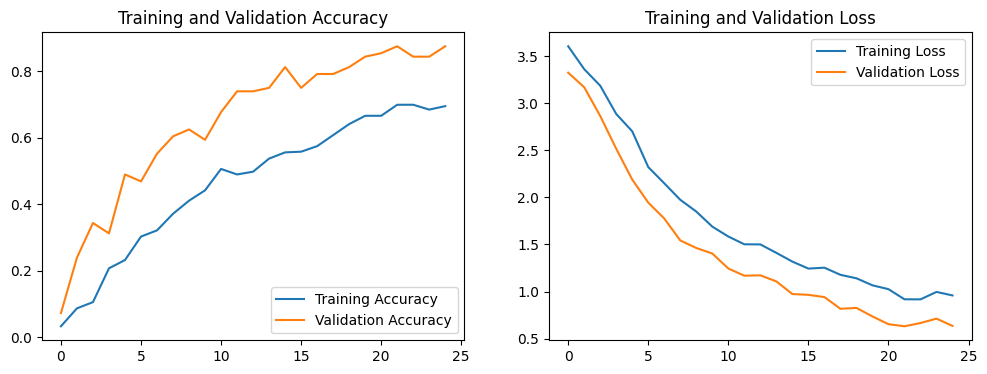

<IPython.core.display.Javascript object>

In [26]:
plot_train_val_history(vgg_model_history, epochs=30)

### EfficientNetV2L Model

In [10]:
# hyperparameter argument dictionary
efficient_arg_dict = {
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
    "preprocessing_function": efficientnet_v2_preprocess,
}

efficient_image_dict = {"target_size": (224, 224), "batch_size": 32}

# base model
efficient = EfficientNetV2L(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),
    pooling="avg",
    include_preprocessing=True,
)

# create image generators for train, test and validation set
efficient_train_generator, efficient_validation_generator = create_image_generators(
    bact_path, efficient_arg_dict, efficient_image_dict
)
efficient_test_generator = create_image_test_generators(
    test_path, efficientnet_v2_preprocess, efficient_image_dict
)

# Add head layers and classification layer to Efficient base model
efficient = add_head_to_base_model(
    efficient, num_classes=33, dense_size=512, dropout_size=0.2
)

# Set training callbacks
callbacks = set_callbacks(bact_path)

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
Found 66 images belonging to 33 classes.


In [36]:
efficient_model, efficient_model_history = train_image_model(
    efficient,
    efficient_train_generator,
    efficient_validation_generator,
    num_epochs=30,
    init_lr=0.0001,
    callbacks=callbacks,
)

Epoch 1/30
16/16 [==============================] - 274s 16s/step - loss: 3.4615 - sparse_categorical_accuracy: 0.0353 - val_loss: 3.3717 - val_sparse_categorical_accuracy: 0.1146
Epoch 2/30
16/16 [==============================] - 280s 18s/step - loss: 3.3154 - sparse_categorical_accuracy: 0.1639 - val_loss: 3.2106 - val_sparse_categorical_accuracy: 0.2917
Epoch 3/30
16/16 [==============================] - 281s 18s/step - loss: 3.1540 - sparse_categorical_accuracy: 0.2676 - val_loss: 3.0536 - val_sparse_categorical_accuracy: 0.4896
Epoch 4/30
16/16 [==============================] - 278s 18s/step - loss: 2.9726 - sparse_categorical_accuracy: 0.4440 - val_loss: 2.8526 - val_sparse_categorical_accuracy: 0.5104
Epoch 5/30
16/16 [==============================] - 277s 17s/step - loss: 2.7802 - sparse_categorical_accuracy: 0.4668 - val_loss: 2.6413 - val_sparse_categorical_accuracy: 0.5417
Epoch 6/30
16/16 [==============================] - 274s 17s/step - loss: 2.5620 - sparse_categorica

<IPython.core.display.Javascript object>

In [39]:
# Save model
efficient_model.save(
    "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/EfficientNetV2L_model/"
)

INFO:tensorflow:Assets written to: C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/EfficientNetV2L_model/assets


<IPython.core.display.Javascript object>

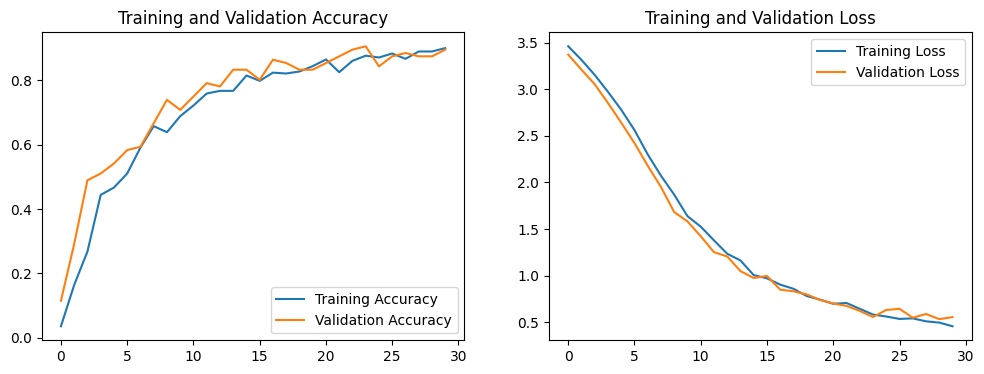

<IPython.core.display.Javascript object>

In [38]:
plot_train_val_history(efficient_model_history, epochs=30)

### Resnet50 Model

In [9]:
# hyperparameter argument dictionary
resnet_arg_dict = {
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
    "preprocessing_function": resnet_preprocess,
}

resnet_image_dict = {"target_size": (224, 224), "batch_size": 32}

# base model
resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),
    pooling="avg",
)

# create image generators for train, test and validation set
resnet_train_generator, resnet_validation_generator = create_image_generators(
    bact_path, resnet_arg_dict, resnet_image_dict
)
resnet_test_generator = create_image_test_generators(
    test_path, resnet_preprocess, resnet_image_dict
)

# Add head layers and classification layer to Resnet base model
resnet = add_head_to_base_model(
    resnet, num_classes=33, dense_size=512, dropout_size=0.2
)

# Set training callbacks
callbacks = set_callbacks(bact_path)

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
Found 66 images belonging to 33 classes.


In [72]:
resnet_model, resnet_model_history = train_image_model(
    resnet,
    resnet_train_generator,
    resnet_validation_generator,
    num_epochs=30,
    init_lr=0.001,
    callbacks=callbacks,
)

Epoch 1/30
16/16 [==============================] - 73s 4s/step - loss: 2.5662 - sparse_categorical_accuracy: 0.3050 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.6979
Epoch 2/30
16/16 [==============================] - 76s 5s/step - loss: 1.1312 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.5048 - val_sparse_categorical_accuracy: 0.8021
Epoch 3/30
16/16 [==============================] - 78s 5s/step - loss: 0.6948 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.3268 - val_sparse_categorical_accuracy: 0.8750
Epoch 4/30
16/16 [==============================] - 81s 5s/step - loss: 0.4939 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.2411 - val_sparse_categorical_accuracy: 0.9271
Epoch 5/30
16/16 [==============================] - 82s 5s/step - loss: 0.3734 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.2189 - val_sparse_categorical_accuracy: 0.9167
Epoch 6/30
16/16 [==============================] - 83s 5s/step - loss: 0.3106 - sparse_categorical_accuracy: 

<IPython.core.display.Javascript object>

In [16]:
# Save model
resnet_model.save(
    "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Resnet_model/"
)

INFO:tensorflow:Assets written to: C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Resnet_model/assets


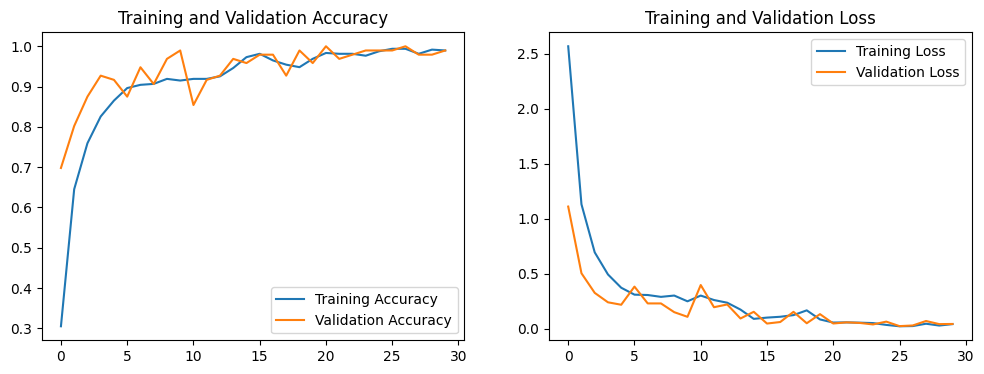

<IPython.core.display.Javascript object>

In [74]:
plot_train_val_history(resnet_model_history, epochs=30)

### InceptionV3 Model

In [4]:
# hyperparameter argument dictionary
inception_arg_dict = {
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
    "preprocessing_function": inception_preprocess,
}

inception_image_dict = {"target_size": (299, 299), "batch_size": 32}

# base model
inception = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(299, 299, 3)),
    pooling="avg",
)

# create image generators for train, test and validation set
inception_train_generator, inception_validation_generator = create_image_generators(
    bact_path, inception_arg_dict, inception_image_dict
)
inception_test_generator = create_image_test_generators(
    test_path, inception_preprocess, inception_image_dict
)

inception = add_head_to_base_model(
    inception, num_classes=33, dense_size=512, dropout_size=0.2
)

# Set training callbacks
callbacks = set_callbacks(bact_path)

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
Found 66 images belonging to 33 classes.


In [5]:
inception_model, inception_model_history = train_image_model(
    inception,
    inception_train_generator,
    inception_validation_generator,
    num_epochs=30,
    init_lr=0.001,
    callbacks=callbacks,
)

Epoch 1/30
16/16 [==============================] - 87s 5s/step - loss: 2.8871 - sparse_categorical_accuracy: 0.2158 - val_loss: 1.6249 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/30
16/16 [==============================] - 94s 6s/step - loss: 1.5024 - sparse_categorical_accuracy: 0.5456 - val_loss: 0.8255 - val_sparse_categorical_accuracy: 0.7292
Epoch 3/30
16/16 [==============================] - 102s 6s/step - loss: 1.0539 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.7812
Epoch 4/30
16/16 [==============================] - 103s 6s/step - loss: 0.8714 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.8333
Epoch 5/30
16/16 [==============================] - 102s 6s/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.7292
Epoch 6/30
16/16 [==============================] - 102s 6s/step - loss: 0.5860 - sparse_categorical_accura

In [6]:
# Save model
inception_model.save(
    "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Inception_model/"
)

INFO:tensorflow:Assets written to: C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Inception_model/assets


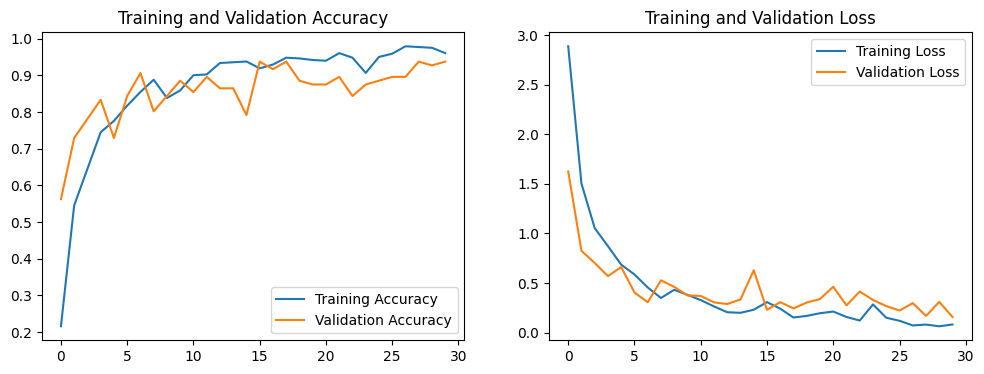

In [7]:
plot_train_val_history(inception_model_history, epochs=30)

## Evaluate all Models

In [14]:
resnet_model = keras.models.load_model( "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Resnet_model/")
eval_output = test_classifier(resnet_model, resnet_test_generator)
print("Resnet test accuracy: {}% \n".format(round(eval_output[1] * 100), 3))

# vgg_model = keras.models.load_model( "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/VGG19_model/")
# eval_output = test_classifier(vgg_model, vgg_test_generator)
# print("VGG19 test accuracy: {}% \n".format(round(eval_output[1] * 100), 3))

efficient_model = keras.models.load_model( "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/EfficientNetV2L_model/")
eval_output = test_classifier(efficient_model, efficient_test_generator)
print("EfficientV2L test accuracy: {}% \n".format(round(eval_output[1] * 100), 3))

inception_model = keras.models.load_model( "C:/Users/rparg/Documents/Data/bacteria_classifier/saved_models/Inception_model/")
eval_output = test_classifier(inception_model, inception_test_generator)
print("Inception test accuracy: {}% \n".format(round(eval_output[1] * 100), 3))

3/3 [==============================] - 8s 2s/step - loss: 0.2474 - sparse_categorical_accuracy: 0.9394
Resnet test accuracy: 94% 

3/3 [==============================] - 29s 6s/step - loss: 0.6529 - sparse_categorical_accuracy: 0.8333
EfficientV2L test accuracy: 83% 

3/3 [==============================] - 11s 2s/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8788
Inception test accuracy: 88% 



### Custom Model

In [51]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[1]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.45540777 0.96952206


In [46]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
16/16 [==============================] - 11s 645ms/step - loss: 0.7268 - accuracy: 0.7620 - val_loss: 1.8333 - val_accuracy: 0.4355
Epoch 2/20
16/16 [==============================] - 11s 649ms/step - loss: 0.8029 - accuracy: 0.7220 - val_loss: 1.8404 - val_accuracy: 0.5000
Epoch 3/20
16/16 [==============================] - 11s 651ms/step - loss: 0.5866 - accuracy: 0.8100 - val_loss: 2.0858 - val_accuracy: 0.4194
Epoch 4/20
16/16 [==============================] - 11s 644ms/step - loss: 0.4362 - accuracy: 0.8740 - val_loss: 2.0860 - val_accuracy: 0.4435
Epoch 5/20
16/16 [==============================] - 11s 646ms/step - loss: 0.3863 - accuracy: 0.8800 - val_loss: 2.5793 - val_accuracy: 0.5242
Epoch 6/20
16/16 [==============================] - 12s 652ms/step - loss: 0.6988 - accuracy: 0.7780 - val_loss: 2.2315 - val_accuracy: 0.4032
Epoch 7/20
16/16 [==============================] - 11s 637ms/step - loss: 0.5058 - accuracy: 0.8620 - val_loss: 2.3501 - val_accuracy: 0.4516

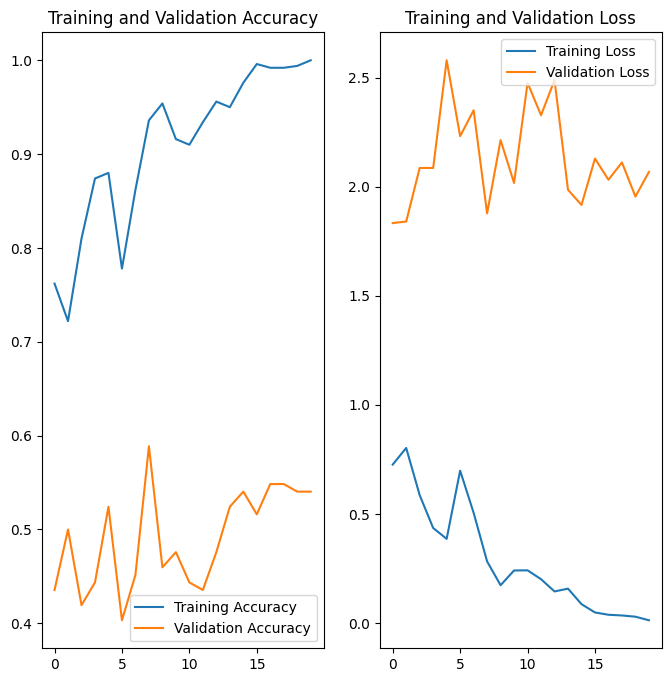

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()